In [1]:
# import 
import pandas as pd
import warnings  
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import sys 
import pickle
import mpltern
import plotly.express as px
import plotly.graph_objects as go 
import matplotlib.image as mpimg 
import matplotlib.patches as mpatches
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import confusion_matrix, cohen_kappa_score 
import statsmodels.formula.api as smf
from PIL import Image
# Load libraries
sys.path.append('../') 
sys.path.insert(0,'/Users/linlin/Library/Mobile Documents/com~apple~CloudDocs/Desktop/2024/AD lab/dataexp/pySuStaIn/sim')
import os 
import pySuStaIn  
from plotly.offline import init_notebook_mode  
import plotly.io as pio
from plotly.graph_objs import * 
init_notebook_mode(connected=True)
pio.renderers.default = 'notebook_connected'
# import the python packages needed to generate simulated data for the tutorial
from termcolor import colored 
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import ttest_1samp, f_oneway, kurtosis, skew , ttest_ind, norm, t 

# column order 
lobes = ['L_MTL', 'R_MTL', 'L_temporal', 'R_temporal', 'L_frontal', 'R_frontal', 
         'L_occipital', 'R_occipital','L_parietal', 'R_parietal' ]
data_path = "/Users/linlin/Desktop/brain stuff/data/"  


In [2]:
# eligibility check
cn_exclude = ["LDS0220099", "LDS0110254", "LDS0670457", "LDS0370222"]
eoad_exclude = ["LDS0100607", "LDS0160473", "LDS0220084", "LDS0220159", "LDS0360398", "LDS0730183", "LDS0980440", "LDS0990439", "LDS1770209", "LDS1770310", "LDS1770403", "LDS3600132", "LDS3600550", "LDS3600671"]
ftp_data = pd.read_csv(data_path+'baseline_FTP_6mm.csv')
# read z-scored data (2GMM w/o EOnonAD standardized)
zdata_full = pd.read_csv(data_path+'full_gmm2z_exclude.csv')
zdata = zdata_full[zdata_full.visit==1]
# to numpy
data = zdata[lobes].values
zdata_ctrl = zdata[zdata.dx == 'CN'][lobes].values
zdata_eoad = zdata[zdata.dx == 'EOAD'][lobes].values
zmax = np.ceil(zdata[lobes].apply(max,axis=0)).values  
thre = pd.read_csv(data_path+'2gmm_thre_exclude.csv') 
#thre = thre[['roi','intersection','c2mean-sd','c2mean+sd']]
thre = thre[['roi','intersection','c2mean']]#thre[['roi','c2mean-sd','c2mean','c2mean+sd']] 
#print('fixed thresholds: 2, 5, 10')
print('ROI-specific thresholds: intersection, c2mean')
pd.concat([thre,pd.DataFrame({'max':zmax})],axis=1)


ROI-specific thresholds: intersection, c2mean


,roi,intersection,c2mean,max
0,L_MTL,1.133637,5.128765,14.0
1,R_MTL,1.254431,4.920137,13.0
2,L_temporal,1.858691,15.198490,38.0
3,R_temporal,1.970307,14.680046,39.0
4,L_frontal,1.487233,10.733511,33.0
5,R_frontal,1.801431,9.984381,34.0
6,L_occipital,2.207846,15.404934,52.0
7,R_occipital,2.044334,14.923082,55.0
8,L_parietal,2.122259,16.583604,43.0
9,R_parietal,2.116481,18.069873,47.0


In [3]:
# Input the settings for z-score SuStaIn 
N = 10         # number of biomarkers
M = 365 # number of observations ( e.g. subjects )
M_control = 0   # number of these that are control subjects
N_startpoints = 25 #25
#N_S_gt = 1 #number of ground truth subtypes
N_S_max = 6 #7
N_iterations_MCMC = int(1e6) #1e4 / 1e6

SuStaInLabels = lobes
Z_vals = thre[['intersection','c2mean']].values#,'c2mean+sd']].values #np.array([[2,5,10]]*N) ## thre[['intersection','c2mean-sd','c2mean+sd']].values  # Z-scores for each biomarker
Z_max = zmax  #z95 #np.array([10]*N)           # maximum z-score 
output_folder = os.path.join(os.getcwd(),'inter_c2mean')#'inter_c2mean_sd_e6'#c2mean_sd_e6
dataset_name = '2GMMz' 
sustain_input = pySuStaIn.ZscoreSustain(zdata_eoad,
                                             Z_vals,
                                             Z_max,
                                             SuStaInLabels,
                                             N_startpoints,
                                             N_S_max, 
                                             N_iterations_MCMC, 
                                             output_folder, 
                                             dataset_name, 
                                             True)
print(f'reading output from: {output_folder}')

reading output from: /Users/linlin/Library/Mobile Documents/com~apple~CloudDocs/Desktop/cap.nosync/sustain_ml/notebooks/inter_c2mean


In [4]:
df = pd.DataFrame(zdata_eoad,columns=lobes)
# The SuStaIn output has everything we need. We'll use it to populate our dataframe.

s = 2
pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
pk = pd.read_pickle(pickle_filename_s)

for variable in ['ml_subtype', # the assigned subtype
                 'prob_ml_subtype', # the probability of the assigned subtype
                 'ml_stage', # the assigned stage 
                 'prob_ml_stage',]: # the probability of the assigned stage
    
    # add SuStaIn output to dataframe
    df.loc[:,variable] = pk[variable] 

# let's also add the probability for each subject of being each subtype
for i in range(s):
    df.loc[:,'prob_S%s'%i] = pk['prob_subtype'][:,i]

# IMPORTANT!!! The last thing we need to do is to set all "Stage 0" subtypes to their own subtype
# We'll set current subtype (0 and 1) to 1 and 0, and we'll call "Stage 0" individuals subtype 0.

# make current subtypes (0 and 1) 1 and 2 instead
df.loc[:,'ml_subtype'] = df.ml_subtype.values + 1

# convert "Stage 0" subjects to subtype 0
#df.loc[df.ml_stage==0,'ml_subtype'] = 0

# change prob_sx to handle diff number of subtypes
df.reset_index() 
df['prob_S2'] = 1 - df['prob_S0']- df['prob_S1']  #- df['prob_S2'] #- df['prob_S3'] - df['prob_S4'] 
df['subj'] = zdata[zdata.dx=='EOAD'].subj.values

# adjustment to reassign subtype based on prevalence
# Step 1: Count current subtype prevalence
prevalence = df['ml_subtype'].value_counts().sort_values(ascending=False)

# Step 2: Create a mapping for reassigning subtypes in order of prevalence
subtype_mapping = {old: new for new, old in enumerate(prevalence.index, start=1)}

# Step 3: Update ml_subtype using the mapping
df['ml_subtype'] = df['ml_subtype'].map(subtype_mapping)

# Step 4: Update probability columns to reflect the new subtype order
prob_columns = ['prob_S0', 'prob_S1', 'prob_S2']#,'prob_S3']
prob_mapping = {0: 'prob_S0', 1: 'prob_S1', 2: 'prob_S2'}#,3: 'prob_S3'}
# Reassign probabilities based on new subtype mapping
for new_subtype, old_subtype in subtype_mapping.items():
    df[f'prob_s{int(new_subtype) - 1}'] = df[prob_mapping[old_subtype - 1]]

# Drop old probability columns  
for col in prob_columns:
    if col not in [f'prob_s{new - 1}' for new in subtype_mapping.values()]:
        df.drop(columns=col, inplace=True)
#print(df.columns)
print('baseline subtype count:')
df.ml_subtype.value_counts()


baseline subtype count:


ml_subtype
1    148
2    111
3    106
Name: count, dtype: int64

/Users/linlin/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/linlin/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/linlin/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



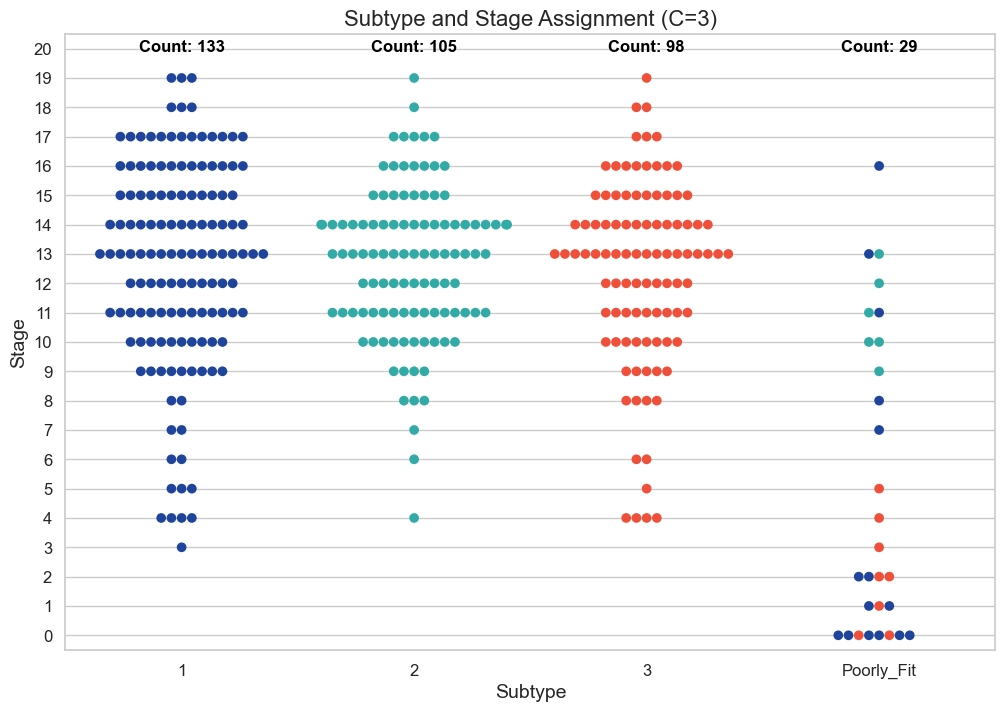

Poorly fit subjects (could be stage 0):
['LDS0070590' 'LDS0110041' 'LDS0110219' 'LDS0220252' 'LDS0220334'
 'LDS0220658' 'LDS0360268' 'LDS0360627' 'LDS0370343' 'LDS0370609'
 'LDS0370646' 'LDS0730044' 'LDS0730103' 'LDS0730141' 'LDS0990409'
 'LDS0990430' 'LDS0990493' 'LDS0990523' 'LDS1770059' 'LDS1770129'
 'LDS1770145' 'LDS1770181' 'LDS1770501' 'LDS3600421' 'LDS3600571'
 'LDS9410149' 'LDS9410288' 'LDS9410450' 'LDS9410622']


In [5]:
 

# Ensure there are no infinite values
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Copy the DataFrame
ptdf = df.copy()

# Explicitly cast ml_subtype to object to allow assignment of 'Poorly_Fit'
ptdf['ml_subtype'] = ptdf['ml_subtype'].astype(object)

# Create a backup of ml_subtype for hue coloring
ptdf['ml_subtype0'] = ptdf['ml_subtype']

# Replace subtype values with 'Poorly_Fit' for prob_ml_subtype <= 0.5
ptdf.loc[ptdf['prob_ml_subtype'] <= 0.8, 'ml_subtype'] = 'Poorly_Fit'

# Set order of categories based on the subtype column
subtype_order = [1, 2, 3, 'Poorly_Fit']

# Define custom colors for each subtype
custom_palette = {
    1: "#1f449c",  # Dark Blue
    2: "#32ABA6",  # Green
    3: "#f05039",  # Red
   # 4: "purple",  # Red
    "Poorly_Fit": "#7f7f7f"  # Grey
}

# Plot the graph using seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))  # Increase figure size for better readability

# Create the swarm plot with hue, ordered by ml_subtype
ax = sns.swarmplot(
    data=ptdf, 
    x='ml_subtype', 
    y='ml_stage', 
    hue='ml_subtype0', 
    palette=custom_palette, 
    order=subtype_order,
    size = 7
)

# Remove legend
plt.legend().remove()

# Adjust font size of labels and title
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Subtype', fontsize=14)
plt.ylabel('Stage', fontsize=14)
plt.title('Subtype and Stage Assignment (C=3)', fontsize=16)

# Set y-tick marks to range from 0 to 30
ax.set_yticks(range(0, 21, 1))
ax.set_ylim(-0.5, 20.5)

# Calculate total count for each subtype
subtype_counts = ptdf['ml_subtype'].value_counts()

# Annotate the plot with the total count for each subtype
for i, subtype in enumerate(subtype_order):
    if subtype in subtype_counts:
        count = subtype_counts[subtype]
        ax.text(i, ptdf['ml_stage'].max() + 0.9, f'Count: {count}', 
                ha='center', fontsize=12, color='black', weight='bold')

plt.show()

# Print poorly fit subjects (including stage 0)
print('Poorly fit subjects (could be stage 0):')
poorly_fit_subjects = zdata[zdata.dx == 'EOAD'].loc[(ptdf['prob_ml_subtype'] <= 0.8).values, 'subj'].values
print(poorly_fit_subjects)


In [6]:
# Function to calculate IQR
def calculate_iqr(x):
    return np.percentile(x, 75) - np.percentile(x, 25)

# Group by 'ml_subtype' and calculate descriptive statistics
descriptive_stats = (
    ptdf[ptdf.ml_subtype.isin([1, 2, 3,4])]
    .groupby('ml_subtype')['ml_stage']
    .apply(lambda x: pd.Series({
        'q1': round(np.percentile(x.dropna(), 25), 2),
        'q3': round(np.percentile(x.dropna(), 75), 2),
        'iqr': round(np.percentile(x.dropna(), 75) - np.percentile(x.dropna(), 25), 2),
        'mean': round(x.mean(), 2),
        'std': round(x.std(), 2),
        'kurtosis': round(kurtosis(x, nan_policy='omit'), 2),
        'skewness': round(skew(x, nan_policy='omit'), 2) 
    }))
)
 

# Reset index for better readability
descriptive_stats = descriptive_stats.reset_index()
# Pivot the table to wide format
descriptive_stats_wide = descriptive_stats.pivot(
    index='ml_subtype', 
    columns='level_1', 
    values='ml_stage'
).reset_index()

# Rename the columns for better readability
descriptive_stats_wide.columns.name = None  # Remove the column group name
descriptive_stats_wide = descriptive_stats_wide.rename_axis(None, axis=1)  # Remove index axis name

# Display the wide-format table
print("Descriptive statistics for SuStaIn stage by subtype:")
descriptive_stats_wide[['ml_subtype', 'q1', 'q3','iqr',  'mean',  'std','kurtosis', 'skewness']]
 

Descriptive statistics for SuStaIn stage by subtype:


,ml_subtype,q1,q3,iqr,mean,std,kurtosis,skewness
0,1,11.0,15.0,4.0,12.63,3.58,-0.01,-0.60
1,2,11.0,14.0,3.0,12.66,2.62,0.45,-0.35
2,3,11.0,14.0,3.0,12.36,3.21,0.46,-0.72


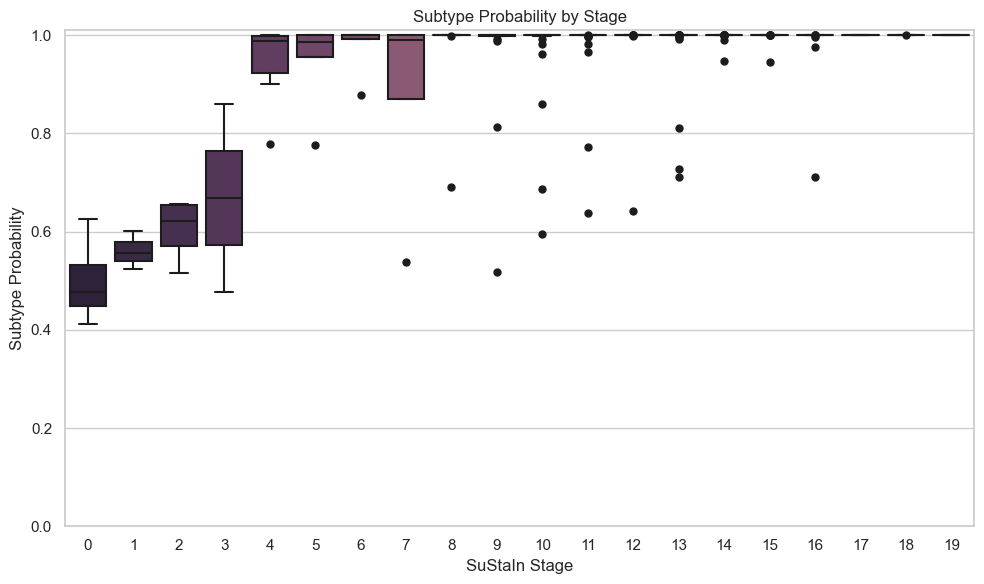

In [7]:
 
# Create reversed colormap
cmap = sns.color_palette("ch:s=-.1,r=.6", as_cmap=True).reversed()

# Get unique, sorted integer ml_stage values
stages = sorted(df['ml_stage'].unique())

# Create stage-to-color mapping
colors = [cmap(i / (len(stages) - 1)) for i in range(len(stages))]
stage_color_map = dict(zip(stages, colors))

# Plot
plt.figure(figsize=(10, 6))

# Seaborn boxplot with custom palette
sns.boxplot(
    data=df,
    x='ml_stage',
    y='prob_ml_subtype',
    palette=stage_color_map,
    flierprops=dict(
        marker='o',
        markersize=5,
        linestyle='none',  # Remove connecting line
    )
)

# Manually match flier (outlier) colors to box colors
ax = plt.gca()
for i, artist in enumerate(ax.artists):
    color = colors[i]
    # Set box color
    artist.set_facecolor(color)

    # Set the color of flier markers for this box
    line_collection = ax.lines[i * 6 + 4]  # Outlier line index pattern
    line_collection.set_color(color)

# Axis formatting
plt.ylim([0,1.01])
plt.title("Subtype Probability by Stage")
plt.xlabel("SuStaIn Stage")
plt.ylabel("Subtype Probability")
plt.xticks(ticks=range(len(stages)), labels=[int(s) for s in stages])  # Ensure integer ticks
plt.tight_layout()
plt.show()


In [8]:
# subtype and stage all scans
new_df = zdata_full[zdata_full.dx == 'EOAD']
typedf = new_df[['subj','visit','ftp_date']]
typedf1 = typedf[typedf.visit==1]
typedf2 = typedf[typedf.visit!=1] 
for i in range(1, N_S_max): #i is the number of split, so starting from 1 split = 2 subtypes
    ##Subtype assignment
    pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(i) + '.pickle'
    pk = pd.read_pickle(pickle_filename_s) 
    subtypes = pk['ml_subtype']
    stages = pk['ml_stage']
    styp_prob = pk['prob_ml_subtype']
    #subtypes = [subtypes[i] if  styp_prob[i] >= 0.5 else 98 for i in range(len(subtypes))]
    typedf1[str(i+1)] = subtypes
    # Add 1 to the subtype (assuming it's indexed from 0 in original)
    typedf1[str(i+1)] = typedf1[str(i+1)].astype(int) + 1
    # Assign the ml_stage
    stage = str(i+1) + 's'
    typedf1[stage] = stages
    typedf1[stage] = typedf1[stage].astype(int) 
    subtype_prob_name = f'{str(i+1)}_subtype_prob'
    typedf1[subtype_prob_name] = pk['prob_ml_subtype']
    stage_prob_name = f'{str(i+1)}_stage_prob'
    typedf1[stage_prob_name] = pk['prob_ml_stage']

    
    pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(i) + '.pickle'
    pk = pd.read_pickle(pickle_filename_s)
    new_dat = new_df[new_df.visit!=1][lobes].values
    s_seq = pk['samples_sequence']
    s_f = pk['samples_f']
    n_s = 700 - 365
    ml_subtype, prob_ml_subtype, ml_stage, prob_ml_stage, prob_subtype, prob_stage, prob_subtype_stage = \
        pySuStaIn.ZscoreSustain.subtype_and_stage_individuals_newData(sustain_input, data_new = new_dat, 
    samples_sequence = s_seq, samples_f = s_f , N_samples = n_s)
    # if the probability is smaller than 0.5, poorly fit
    subtypes = ml_subtype#[ml_subtype[i] if prob_ml_subtype[i] >= 0.5 else 98 for i in range(len(ml_subtype))]
    typedf2[str(i+1)] = subtypes
    # Add 1 to the subtype (assuming it's indexed from 0 in original)
    typedf2[str(i+1)] = typedf2[str(i+1)].astype(int) + 1
    # Assign the ml_stage
    stage = str(i+1) + 's'
    typedf2[stage] = ml_stage
    typedf2[stage] = typedf2[stage].astype(int) 
    subtype_prob_name = f'{str(i+1)}_subtype_prob'
    typedf2[subtype_prob_name] = prob_ml_subtype
    stage_prob_name = f'{str(i+1)}_stage_prob'
    typedf2[stage_prob_name] = prob_ml_stage
typedf = pd.concat([typedf1,typedf2],axis=0,ignore_index=True)
typedf['fname'] = typedf.apply(lambda row:f"wr{row['subj']}_FTP_{row['ftp_date']}_suvr-infcblgm.nii",axis=1)

/var/folders/zm/03ps49bx5fsdfvh986zjlbr00000gn/T/ipykernel_66061/618022937.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/zm/03ps49bx5fsdfvh986zjlbr00000gn/T/ipykernel_66061/618022937.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/zm/03ps49bx5fsdfvh986zjlbr00000gn/T/ipykernel_66061/618022937.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [9]:
typedf99 = typedf.copy()
for n_clusters in range(2, 7):
    prob_col = f"{n_clusters}_subtype_prob"
    subtype_col = f"{n_clusters}"
    typedf99.loc[typedf99[prob_col] < 0.8, subtype_col] = 99

In [10]:
typedf99.columns

Index(['subj', 'visit', 'ftp_date', '2', '2s', '2_subtype_prob',
       '2_stage_prob', '3', '3s', '3_subtype_prob', '3_stage_prob', '4', '4s',
       '4_subtype_prob', '4_stage_prob', '5', '5s', '5_subtype_prob',
       '5_stage_prob', '6', '6s', '6_subtype_prob', '6_stage_prob', 'fname'],
      dtype='object')

In [11]:
ss = typedf99.copy()
ss = ss[['subj', 'visit', 'ftp_date', '3', '3s', '3_subtype_prob', '3_stage_prob', 'fname']]
ss.columns = ['subj', 'visit', 'ftp_date', 'subtype', 'stage', 'subtype_prob', 'stage_prob', 'fname']
ss['subtype'] = ss['subtype'].astype(int)
ss['stage'] = ss['stage'].astype(int)
#data = pd.read_csv(data_path + 'full_combined.csv')  # Convert ftp_date to datetime in both DataFrames 
data = pd.read_csv(data_path+'tableone_dat.csv' )
data['ftp_date'] = pd.to_datetime(data['ftp_date'], errors='coerce')
data.drop(columns=["visit",'subtype','stage','subtype_prob','stage_prob','fname'],inplace=True) 
ss['ftp_date'] = pd.to_datetime(ss['ftp_date'], errors='coerce')
combined = pd.merge(data, ss, on=['subj', 'ftp_date'], how='right')
combined = combined.sort_values(by=['subj', 'ftp_date']).reset_index(drop=True)
combined['visit'] = combined.groupby('subj').cumcount() + 1
#subtype_mapping = {old: new for new, old in enumerate(prevalence.index, start=1)}
#ombined['subtype'] = combined['subtype'].map(subtype_mapping)
combined['poorly'] = combined['subtype_prob'] < 0.8
combined_bl = combined[combined['visit']==1]
prevalence = combined_bl['subtype'].value_counts().sort_values(ascending=False)
combined_exclude = combined_bl[~combined_bl.poorly]
print('baseline prevalence')
print(combined_exclude.subtype.value_counts())
print(f'total scans: {len(combined)}')
print('variables:')
print(combined.columns)


/var/folders/zm/03ps49bx5fsdfvh986zjlbr00000gn/T/ipykernel_66061/2206331051.py:8: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



baseline prevalence
subtype
1    133
2    105
3     98
Name: count, dtype: int64
total scans: 699
variables:
Index(['subj', 'fbb_date', 'amy_file', 'ftp_file', 'ftp_date', 'event',
       'SUVR Frontal', 'SUVR MesialTemporal', 'SUVR MetaTemporal',
       'SUVR TemporoParietal',
       ...
       'ctx_desikan_MRIBASED_SUVR', 'Benson_Forgetting', 'RAVLT_Forgetting',
       'Craft_Forgetting', 'visit', 'subtype', 'stage', 'subtype_prob',
       'stage_prob', 'fname'],
      dtype='object', length=105)


In [12]:
133+105+98

336

In [13]:
from tableone import TableOne

In [18]:
cont = [ 'Centiloids MRI-Based Composite',
       'Yrs. of Education','Age', 'CDR-SB',# 'Total 13','Delayed Recall',
       'SUVR Frontal', 'SUVR MesialTemporal', 'SUVR MetaTemporal', 'SUVR TemporoParietal',
       'MMSE','stage',  'SUVR Universal','ctx_desikan_MRIBASED_SUVR','meta_temporal_MRIBASED_SUVR', 
"mtl_no_hippocampus_MRIBASED_SUVR",
"basolateral_temporal_MRIBASED_SUVR",  
"temporoparietal_MRIBASED_SUVR", "SUVR MRI-Based Composite","MOCATOTS"]
cat = ['Gender', 'Diagnosis', 'ApoE4 Carrier','Cognitive Behavior','ApoE4 Genotype'] 
#'CDR-Global',
print('check subtype ordering (excluding poorly fit):')
tdata = combined_bl[~combined_bl.poorly][cont+cat+['subtype']].copy() #exclude poorly classified scans
tdata['Clinical Phenotype'] = tdata['Cognitive Behavior']
cat = ['Gender', 'Diagnosis', 'ApoE4 Carrier','Clinical Phenotype','ApoE4 Genotype']
#tdata['CDR-Global'] = tdata['CDR-Global'].astype('str').replace({'nan':None})
print(tdata.subtype.value_counts())
 
t1 = TableOne(data=tdata[tdata.subtype.isin([1,2,3])], columns=cont+cat, categorical=cat, groupby='subtype', pval=True,row_percent=False)
t1.to_csv('tmp_table_senspt8.csv')
t1 = pd.read_csv('tmp_table_senspt8.csv').iloc[2:,:]
t1.columns = ['variable','category','missing','overall','1','2','3','p']
t1 

check subtype ordering (excluding poorly fit):
subtype
1    133
2    105
3     98
Name: count, dtype: int64


,variable,category,missing,overall,1,2,3,p
2,"Centiloids MRI-Based Composite, mean (SD)",NaN,0,104.4 (27.4),105.9 (29.0),103.0 (25.0),103.8 (27.8),0.694
3,"Yrs. of Education, mean (SD)",NaN,0,15.7 (2.4),15.6 (2.5),15.6 (2.5),15.9 (2.4),0.624
4,"Age, mean (SD)",NaN,0,59.0 (4.0),58.7 (4.1),58.8 (3.9),59.4 (3.9),0.362
5,"CDR-SB, mean (SD)",NaN,3,4.0 (2.0),4.3 (2.3),3.8 (1.8),3.9 (1.7),0.123
6,"SUVR Frontal, mean (SD)",NaN,0,2.4 (0.7),2.7 (0.7),2.4 (0.6),2.2 (0.7),<0.001
7,"SUVR MesialTemporal, mean (SD)",NaN,0,2.0 (0.3),2.1 (0.4),2.1 (0.3),1.9 (0.3),0.001
8,"SUVR MetaTemporal, mean (SD)",NaN,0,2.5 (0.5),2.5 (0.6),2.5 (0.4),2.3 (0.5),<0.001
9,"SUVR TemporoParietal, mean (SD)",NaN,0,2.6 (0.6),2.7 (0.7),2.7 (0.5),2.5 (0.6),0.059
10,"MMSE, mean (SD)",NaN,9,21.0 (5.3),20.8 (5.7),20.5 (5.6),21.9 (4.5),0.146
11,"stage, mean (SD)",NaN,0,12.6 (3.2),12.6 (3.6),12.7 (2.6),12.4 (3.2),0.757


In [15]:
TableOne(data=tdata[tdata.subtype.isin([1,2,3,4])], columns=cont+cat, categorical=cat, groupby='subtype', pval=True,row_percent=True)


Grouped by subtype                                                                
                                                                                                   Missing       Overall             1             2             3 P-Value
n                                                                                                                    336           133           105            98        
SUVR MRI-Based Composite, mean (SD)                                                                      3     1.6 (0.2)     1.6 (0.2)     1.6 (0.2)     1.6 (0.2)   0.763
Centiloids MRI-Based Composite, mean (SD)                                                                0  104.4 (27.4)  105.9 (29.0)  103.0 (25.0)  103.8 (27.8)   0.694
Yrs. of Education, mean (SD)                                                                             0    15.7 (2.4)    15.6 (2.5)    15.6 (2.5)    15.9 (2.4)   0.624
Age, mean (SD)                                                                                           0    59.0 (4.0)    58.7 (4.1)    58.8 (3.9)    59.4 (3.9)   0.362
CDR-SB, mean (SD)                                                                                        3     4.0 (2.0)     4.3 (2.3)     3.8 (1.8)     3.9 (1.7)   0.123
MMSE, mean (SD)                                                                                          9    21.0 (5.3)    20.8 (5.7)    20.5 (5.6)    21.9 (4.5)   0.146
stage, mean (SD)                                                                                         0    12.6 (3.2)    12.6 (3.6)    12.7 (2.6)    12.4 (3.2)   0.757
SUVR Universal, mean (SD)                                                                                0     2.6 (0.6)     2.6 (0.6)     2.6 (0.5)     2.5 (0.6)   0.143
Gender, n (%)                             Female                                                             187 (100.0)     73 (39.0)     60 (32.1)     54 (28.9)   0.933
                                          Male                                                               149 (100.0)     60 (40.3)     45 (30.2)     44 (29.5)        
Diagnosis, n (%)                          Dementia                                                           256 (100.0)    103 (40.2)     79 (30.9)     74 (28.9)   0.628
                                          MCI                                                                 79 (100.0)     30 (38.0)     26 (32.9)     23 (29.1)        
                                          None                                                                 1 (100.0)                                 1 (100.0)        
ApoE4 Carrier, n (%)                      Carrier                                                            183 (100.0)     67 (36.6)     57 (31.1)     59 (32.2)   0.668
                                          Non carrier                                                        145 (100.0)     63 (43.4)     45 (31.0)     37 (25.5)        
                                          None                                                                 8 (100.0)      3 (37.5)      3 (37.5)      2 (25.0)        
Clinical Phenotype, n (%)                 Amnestic-predominant CI (single/multi-domain)                      269 (100.0)    114 (42.4)     83 (30.9)     72 (26.8)  <0.001
                                          Non-amnestic CI (single/multi-domain)                               20 (100.0)     10 (50.0)      6 (30.0)      4 (20.0)        
                                          PCA                                                                 24 (100.0)      3 (12.5)       2 (8.3)     19 (79.2)        
                                          PPA                                                                 23 (100.0)      6 (26.1)     14 (60.9)      3 (13.0)        
ApoE4 Genotype, n (%)                     Heterozygote                                                       133 (100.0)     47 (35.3)     42 (31.6)     44

In [22]:
ff = pd.read_csv(data_path+"inter_c2mean_ss_fname_bl.csv")
ff['subtype']=ff['subj'].map(dict(zip(combined_bl.subj,combined_bl.subtype)))
ff['stage']=ff['subj'].map(dict(zip(combined_bl.subj,combined_bl.stage)))
ff.to_csv(data_path+"sense_pt8_threshold.csv",index=False)

In [17]:
combined_bl.columns

Index(['subj', 'fbb_date', 'amy_file', 'ftp_file', 'ftp_date', 'event',
       'SUVR Frontal', 'SUVR MesialTemporal', 'SUVR MetaTemporal',
       'SUVR TemporoParietal', 'SUVR Universal', 'SUVR PET-Only Composite',
       'SUVR MRI-Based Composite', 'Centiloids MRI-Based Composite', 'Gender',
       'Yrs. of Education', 'Age', 'Diagnosis', 'CDR-SB', 'CDR-Global', 'MMSE',
       'Total 13', 'ApoE4', 'ApoE4 Carrier', 'ApoE4 Genotype',
       'Delayed Recall', 'Digit Total', 'Cognitive Behavior', 'Language CI',
       'Attention CI', 'Executive CI', 'Visuospatial CI', 'Memory CI', 'L_MTL',
       'R_MTL', 'L_temporal', 'R_temporal', 'L_frontal', 'R_frontal',
       'L_occipital', 'R_occipital', 'L_parietal', 'R_parietal', 'L_MTL_z',
       'R_MTL_z', 'L_temporal_z', 'R_temporal_z', 'L_frontal_z', 'R_frontal_z',
       'L_occipital_z', 'R_occipital_z', 'L_parietal_z', 'R_parietal_z',
       'visit', 'subtype', 'stage', 'subtype_prob', 'stage_prob', 'fname',
       'poorly'],
      dtype='o